## **AUTHOR: RAKESH ADHIKARI (rakesh.adhikari@fractal.ai)**

### Install Relevant Dependencies

In [1]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install langgraph
!pip install langchain-experimental
!pip install unstructured[all-docs]
!pip install langchain-core


### Storing the Open API Key

In [2]:
from getpass import getpass
OPENAI_KEY = getpass("Enter Open AI API Key...")

Enter Open AI API Key...··········


### Setting Env Variables

In [3]:
import os
os.environ["OPENAI_API_KEY"] = OPENAI_KEY

### Setting Up Document Information Structure

In [4]:
from typing import TypedDict, Literal
from pydantic import BaseModel
from typing_extensions import Annotated
import operator

class DocumentParserSupportState(TypedDict):
    file_path_name: str
    current_status: Annotated[list[str], operator.add]
    final_answer: Annotated[list[str], operator.add]
    agent_logs: Annotated[list[dict], operator.add]
    reader_agent_output: Annotated[list[str], operator.add]
    risk_critic_agent_output: Annotated[list[str], operator.add]
    decision_agent_output: Annotated[list[str], operator.add]
    validator_agent_output: Annotated[list[str], operator.add]


### Setting Up the AI Chat Model

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4.1", temperature=0)

### Load Document as per format
### **DOCUMENT LOADER AGENT NODE**

In [18]:
# Document Loader Agent (returns full state)
from langchain_community.document_loaders import UnstructuredWordDocumentLoader
from langchain.document_loaders import PyMuPDFLoader, TextLoader

def document_loader_agent(support_state: DocumentParserSupportState) -> DocumentParserSupportState:
    print("[DEBUG] Document Loader Agent Invoked:")

    file_path_name = support_state.get("file_path_name")
    file_extension = os.path.splitext(file_path_name)[1]
    agent_logs = support_state.get("agent_logs", [])

    loaders = {
        '.pdf': (PyMuPDFLoader, {}),
        '.docx': (UnstructuredWordDocumentLoader, {}),
        '.txt': (TextLoader, {})
    }

    try:
        if file_extension not in loaders:
            raise ValueError(f"Unsupported file type: {file_extension}")

        loader_cls, loader_kwargs = loaders[file_extension]
        loader = loader_cls(file_path_name, **loader_kwargs)
        documents = loader.load()
        if not documents:
            raise ValueError("No content found in document.")

        document_texts = [doc.page_content for doc in documents]
        support_state["final_answer"] = document_texts
        support_state["current_status"].append("Document Loader Agent Completed")
        agent_logs.append({"agent": "Document Loader Agent", "status": "success", "message": "Loaded document."})
        support_state["agent_logs"] = agent_logs

        print(f"""[DEBUG] Document Loader Agent Completed With Loading :{len(document_texts)} Document""")
        return support_state

    except Exception as e:
        error_msg = f"Document Loader Agent Error: {str(e)}"
        support_state["final_answer"] = [error_msg]
        support_state["current_status"].append("Document Loader Agent Failed")
        agent_logs.append({"agent": "Document Loader Agent", "status": "error", "message": error_msg})
        support_state["agent_logs"] = agent_logs
        return support_state


### READER AGENT
### Reads the document loaded and extract obligations, rights, deadlines

In [20]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from concurrent.futures import ThreadPoolExecutor

# Sub-node for obligations
def extract_obligations(documents: str) -> str:
    prompt = ChatPromptTemplate.from_template("""
      Extract only the **Obligations** from the document.
      List all required actions, responsibilities, or duties for both Provider and Recipient.

      Output Format:
      Obligations
      • [obligation 1]
      • [obligation 2]
      ...

      Document:
      {documents}
    """)
    return (prompt | llm).invoke({"documents": documents}).content.strip()

# Sub-node for rights
def extract_rights(documents: str) -> str:
    prompt = ChatPromptTemplate.from_template("""
      Extract only the **Rights** from the document.
      List all permissions, entitlements, or control-related clauses for either party.

      Output Format:
      Rights
      • [right 1]
      • [right 2]
      ...

      Document:
      {documents}
    """)
    return (prompt | llm).invoke({"documents": documents}).content.strip()

#  Sub-node for deadlines
def extract_deadlines(documents: str) -> str:
    prompt = ChatPromptTemplate.from_template("""
      Extract only the **Deadlines** from the document.
      Identify time-bound events, specific dates, or durations.

      Output Format:
      Deadlines
      • [deadline 1]
      • [deadline 2]
      ...

      Document:
      {documents}
    """)
    return (prompt | llm).invoke({"documents": documents}).content.strip()

# reader_agent using parallel sub-nodes
def reader_agent(support_state: DocumentParserSupportState) -> DocumentParserSupportState:
    print("[DEBUG] Reader Agent Invoked:")
    documents = support_state["final_answer"]
    support_state["reader_agent_output"] = []
    agent_logs = support_state.get("agent_logs", [])

    try:
        # Execute all extractors in parallel using ThreadPoolExecutor
        with ThreadPoolExecutor() as executor:
            future_obligations = executor.submit(extract_obligations, documents)
            future_rights = executor.submit(extract_rights, documents)
            future_deadlines = executor.submit(extract_deadlines, documents)

            obligations = future_obligations.result()
            rights = future_rights.result()
            deadlines = future_deadlines.result()

        # Combine outputs
        final_output = f"{obligations}\n\n{rights}\n\n{deadlines}"
        support_state["reader_agent_output"] = [final_output]

        # Update status and logs
        if "Reader Agent Completed" not in support_state["current_status"]:
            support_state["current_status"].append("Reader Agent Completed")
        support_state["agent_logs"].append({
            "agent": "Reader Agent",
            "status": "success",
            "message": "Extracted obligations, rights, and deadlines."
        })

        print(f"""[DEBUG] Reader Agent Completed With Output Length: {len(final_output)}""")
        return support_state

    except Exception as e:
        support_state["reader_agent_output"] = [str(e)]
        support_state["current_status"].append("Reader Agent Failed")
        support_state["agent_logs"].append({
            "agent": "Reader Agent",
            "status": "error",
            "message": str(e)
        })
        return support_state


### Identifying Potential Risks in the Document
### **RISK CRITIC AGENT NODE**

In [21]:
def risk_critic_agent(support_state: DocumentParserSupportState) -> DocumentParserSupportState:
    """
    Goal: Evaluate the structured output from Reader Agent and identify risks, ambiguities, and gaps .
    """
    print("[DEBUG] Risk Critic Agent Invoked with Reader Agent Output")
    support_state["risk_critic_agent_output"] = []
    agent_logs = support_state.get("agent_logs", [])
    reader_agent_output = support_state.get("reader_agent_output", [])

    full_doc_text = reader_agent_output

    risk_critic_prompt = ChatPromptTemplate.from_template("""
    You are a Risk Assessment Analyst. Given obligations, rights, and deadlines from a legal or technical document with transparency and explainability., extract only the risks and vulnerabilities that may arise.
    Focus on:Legal ambiguity,Operational weakness,Enforcement limitations,Security gaps
    Do not summarize or repeat obligations.

    Output Format:
    Use bullet points (•) to list risks concisely:
    Be concise and avoid interpretation or recommendations.
    Do not use Markdown or any special formatting such as asterisks (**), bold, italics, or headings. Output must be plain text only.
    Example Output:

    Risks

    • Liability capped at ₹1 Cr, regardless of breach severity.
    • Model fairness criteria not clearly defined.
    • Audit-only enforcement lacks technical safeguards.

    {documents}

    """)

    try:
        result = (risk_critic_prompt | llm).invoke({"documents": full_doc_text})
        if result.content not in support_state["risk_critic_agent_output"]:
          support_state["risk_critic_agent_output"].append(result.content)
        if "Risk Critic Agent Completed" not in support_state["current_status"]:
            support_state["current_status"].append("Risk Critic Agent Completed")
        support_state["agent_logs"].append({"agent": "Risk Critic Agent Completed", "status": "success", "message": "Analyzed risks."})
        print(f"""[DEBUG] Risk Critic Agent Completed With Output Length:{len(result.content)}""")
        return support_state
    except Exception as e:
        support_state["risk_critic_agent_output"] = [str(e)]
        support_state["current_status"].append("Risk Critic Agent Failed")
        support_state["agent_logs"].append({"agent": "Risk Critic Agent", "status": "error", "message": str(e)})
        return support_state

### Making Recommendations Based on Document Insights
### **DECISION AGENT NODE**

In [22]:
from langchain_core.prompts import ChatPromptTemplate

def decision_agent(support_state: DocumentParserSupportState) -> DocumentParserSupportState:
    """
    Goal: Use extracted data and risks to propose actionable recommendations.
    """
    print("[DEBUG] Decision Agent Invoked with Reader & Risk Agent Output")

    reader_output = support_state.get("reader_agent_output", [])
    risk_output = support_state.get("risk_critic_agent_output", [])
    full_doc_text = "\n\n".join(reader_output + risk_output)
    agent_logs = support_state.get("agent_logs", [])
    support_state["decision_agent_output"] = []


    decision_prompt = ChatPromptTemplate.from_template("""
    You are a Compliance and Policy Advisor.Based on the extracted obligations and risks, suggest concrete, enforceable recommendations to strengthen the agreement with transparency and explainability..
    Focus areas: Privacy,Security,Auditability,Governance

    Technical controls

    Output Format:
    Use bullet points (•) and briefly explain each recommendation:
    Be concise and avoid interpretation or recommendations.
    Do not use Markdown or any special formatting such as asterisks (**), bold, italics, or headings. Output must be plain text only.
    Example Output:

    Recommendations

    • Add cumulative breach penalty cap per quarter — improves deterrence.
    • Include data masking and watermarking — helps detect misuse.
    • Clarify re-identification prohibition with audit clause.
    Do not copy from obligations or mention agent roles.

    {documents}    """)

    try:
        result = (decision_prompt | llm).invoke({"documents": full_doc_text})
        if result.content not in support_state["decision_agent_output"]:
          support_state["decision_agent_output"].append(result.content)

        if "Decision Agent Completed" not in support_state["current_status"]:
            support_state["current_status"].append("Decision Agent Completed")
        support_state["agent_logs"].append({"agent": "Decision Agent Completed", "status": "success", "message": "Analyzed risks."})
        print(f"""[DEBUG] Decision Agent Completed With Output Length:{len(result.content)}""")
        return support_state
    except Exception as e:
        support_state["decision_agent_output"] = [str(e)]
        support_state["current_status"].append("Decision Agent Failed")
        support_state["agent_logs"].append({"agent": "Decision Agent", "status": "error", "message": str(e)})
        return support_state

### Reviewing and Validating Proposed Actions
### **VALIDATOR AGENT NODE**

In [23]:
from langchain_core.prompts import ChatPromptTemplate

def validator_agent(support_state: DocumentParserSupportState) -> DocumentParserSupportState:
    """
    Goal: Validate or challenge the recommendations from the Decision Agent. Ensure robustness, consistency, and traceability.
    """
    print("[DEBUG] Validator Agent Invoked with Decision Agent Output")
    support_state["validator_agent_output"] = []

    decision_output = support_state.get("decision_agent_output", [])
    full_doc_text = "\n\n".join(decision_output)
    agent_logs = support_state.get("agent_logs", [])

    validator_prompt = ChatPromptTemplate.from_template("""
      You are a Validator Agent reviewing a list of recommendations extracted from a legal or compliance agreement.

      ### Your tasks:
      1. For each recommendation:
        - Decide if it should be Approved (clear, enforceable, relevant) or Flagged (ambiguous, redundant, or irrelevant).
        - Provide a short justification explaining your decision.

      2. Your response must follow the exact format below.

      ### Output Format:
      Validation:
      • [Recommendation] — [Approved/Flagged] — [Short justification (max 2 sentences)]

      Do not use Markdown or any special formatting such as asterisks (**), bold, italics, or headings. Output must be plain text only.

      ### Example:
      • Include audit trail for every data access — Approved — Ensures accountability and supports regulatory compliance.
      • Add a blockchain for tracking consent — Flagged — Unnecessary complexity given existing logging solutions.


      ### Begin validating:
      {documents}

    """)


    try:
        result = (validator_prompt | llm).invoke({"documents": full_doc_text})
        if result.content not in support_state["validator_agent_output"]:
          support_state["validator_agent_output"] = [result.content]
        if "Validator Agent Completed" not in support_state["current_status"]:
            support_state["current_status"].append("Validator Agent Completed")
        support_state["agent_logs"].append({"agent": "Validator Agent Completed", "status": "success", "message": "Analyzed risks."})
        print(f"""[DEBUG] Validator Agent Completed With Output Length:{len(result.content)}""")
        return support_state
    except Exception as e:
        support_state["validator_agent_output"] = [str(e)]
        support_state["current_status"].append("Validator Agent Failed")
        support_state["agent_logs"].append({"agent": "Validator Agent", "status": "error", "message": str(e)})
        return support_state

### Building the Document Analysis Workflow

In [24]:
from langgraph.graph import StateGraph, END

def build_fresh_document_parser_graph():
    document_parser_graph = StateGraph(DocumentParserSupportState)

    # Add nodes
    document_parser_graph.add_node("document_loader_agent", document_loader_agent)
    document_parser_graph.add_node("reader_agent", reader_agent)
    document_parser_graph.add_node("risk_critic_agent", risk_critic_agent)
    document_parser_graph.add_node("decision_agent", decision_agent)
    document_parser_graph.add_node("validator_agent", validator_agent)

    # Define edges
    document_parser_graph.set_entry_point("document_loader_agent")
    document_parser_graph.add_edge("document_loader_agent", "reader_agent")
    document_parser_graph.add_edge("reader_agent", "risk_critic_agent")
    document_parser_graph.add_edge("risk_critic_agent", "decision_agent")
    document_parser_graph.add_edge("decision_agent", "validator_agent")
    document_parser_graph.add_edge("validator_agent", END)

    # Compile and return fresh graph
    return document_parser_graph.compile()


### Visualizing the Document Processing Flow

### Running the Multi-Agent Document Review System

In [25]:

from IPython.display import display, Markdown, Image
from typing import LiteralString
def deduplicate_sections_and_bullets(text: str, default_section: str = "General") -> str:
    """
    Deduplicates bullet points and section headers from a block of text.
    If no header is found before bullets, assigns them to a default section.

    Args:
        text: The input text containing sections and bullet points.
        default_section: Fallback section name for bullets without a header.

    Returns:
        A cleaned string with unique sections and bullets, preserving order.
    """
    sections, seen_bullets = {}, set()
    current_section = None

    for line in map(str.strip, text.strip().splitlines()):
        if not line:
            continue
        if line.startswith("•"):
            current_section = current_section or default_section
            sections.setdefault(current_section, [])
            if line not in seen_bullets:
                seen_bullets.add(line)
                sections[current_section].append(line)
        else:
            sections.setdefault(line, [])
            current_section = line

    return "\n".join(
        f"{sec}\n" + "\n".join(bullets) for sec, bullets in sections.items() if bullets
    )


def display_agent_output(title: str, content_list: list):
    print(f"\n{title}\n" + "—" * len(title))
    all_text = "\n".join(content_list).strip()
    print(deduplicate_sections_and_bullets(all_text))

def display_structured_output(result):
    print("\n=== MULTI-AGENT TASK COMPLETION ===")
    print(f"Processed Document: {result.get('file_path_name', 'N/A')}\n")
    # Display each agent output cleanly
    display_agent_output("Reader Agent Output", result.get("reader_agent_output", []))
    display_agent_output("Risk Critic Agent Output", result.get("risk_critic_agent_output", []))
    display_agent_output("Decision Agent Output", result.get("decision_agent_output", []))
    display_agent_output("Validator Agent Output", result.get("validator_agent_output", []))


def run_multi_agent_system(file_name: str):
    compiled_support_agent = build_fresh_document_parser_graph()
    display(Image(compiled_support_agent.get_graph().draw_mermaid_png()))

    initial_state = {
        "file_path_name": file_name,
        "current_status": [],
        "final_answer": [],
        "reader_agent_output": [],
        "risk_critic_agent_output": [],
        "decision_agent_output": [],
        "validator_agent_output": [],
        "agent_logs": []
    }

    result = compiled_support_agent.invoke(initial_state)
    display_structured_output(result)
    return result


### Executing the System on a Sample Document

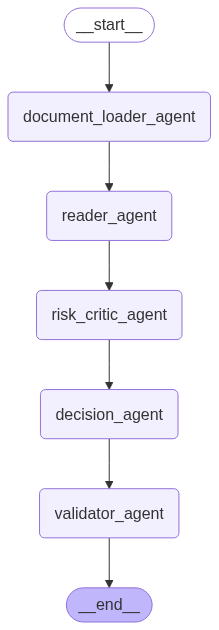

[DEBUG] Document Loader Agent Invoked:
[DEBUG] Document Loader Agent Completed With Loading :1 Document
[DEBUG] Reader Agent Invoked:
[DEBUG] Reader Agent Completed With Output Length: 7148
[DEBUG] Risk Critic Agent Invoked with Reader Agent Output
[DEBUG] Risk Critic Agent Completed With Output Length:1560
[DEBUG] Decision Agent Invoked with Reader & Risk Agent Output
[DEBUG] Decision Agent Completed With Output Length:2281
[DEBUG] Validator Agent Invoked with Decision Agent Output
[DEBUG] Validator Agent Completed With Output Length:2827

=== MULTI-AGENT TASK COMPLETION ===
Processed Document: /content/Procurement Contract.docx


Reader Agent Output
———————————————————
Obligations
• Supplier shall manufacture, supply, install, and commission industrial-grade CNC cutting machines and auxiliary robotic welding systems for Buyer’s facility.
• Supplier shall deliver 3 × Model IFC-9000 CNC plasma cutting machines, 2 × Model RWS-150 Robotic Welding Stations, and 1 × Centralized Control Con

In [26]:
file_path_name= "/content/Procurement Contract.docx"
result = run_multi_agent_system(file_path_name)
